<a target="_blank" href="https://colab.research.google.com/github/chasubeen/Store-Sales-Forecasting/blob/%EC%88%98%EB%B9%88/3.%20EDA_TypeA.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **0. 패키지 로딩**

In [1]:
### 기본
import numpy as np
import pandas as pd
import os
import gc
import warnings

### 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # 동적 시각화

## 옵션 설정
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

### 시계열 분석 패키지(ACF, PACF)
import statsmodels.api as sm

# **1. 데이터 불러오기**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/train_preprocessed.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/test_preprocessed.csv')

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,93.14,0.00,National
1,1,2013-01-01,41,SEAFOOD,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
2,2,2013-01-01,41,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
3,3,2013-01-01,41,PRODUCE,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
4,4,2013-01-01,41,PREPARED FOODS,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705087 entries, 0 to 2705086
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   float64
 6   city          object 
 7   state         object 
 8   type          object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  transactions  float64
 12  holiday       object 
dtypes: float64(4), int64(3), object(6)
memory usage: 268.3+ MB


In [6]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,holiday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,Weekday
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.80,Weekday
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.80,Weekday
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.80,Weekday
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.80,Weekday


In [7]:
# date를 datetime 형으로 변경

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705087 entries, 0 to 2705086
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  holiday       object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 268.3+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
 5   city         28512 non-null  object        
 6   state        28512 non-null  object        
 7   type         28512 non-null  object        
 8   cluster      28512 non-null  int64         
 9   dcoilwtico   28512 non-null  float64       
 10  holiday      28512 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 2.4+ MB


- 제대로 변경되었다.

## **📌 Data Description**
| Index | Column        | Description                     |
|-------|---------------|---------------------------------|
| 1     | id            | 각 데이터를 구분하기 위한 식별자|
| 2     | date          |판매일자                         |
| 3     | store_nbr     |매장 고유 식별번호               |
| 4     | family        |판매되는 제품군 유형             |
| 5     | sales         |매출액, **target 변수**        |
| 6     | onpromotion   |프로모션 대상 제품 수            |
| 7     | city          |도시                             |
| 8     | state         |주                               |
| 9     | type          |매장 유형                        |
| 10    | cluster       |유사한 매장들의 군집             |
| 11    | dcoilwtico    |유가(기름값)                     |
| 12    | transactions  |거래량                           |
| 13    | holiday       |공휴일 종류                      |



# **2. 시계열 분석**
- target 변수에 대한 시계열 분석을 진행해 보자.

In [10]:
### 더이상 일자가 연속될 필요가 없으므로 'sales'가 0인 데이터 삭제

train = train[train['sales'] != 0]

### **3️⃣ 시간 관련 변수**
- 시간적인 정보를 제공하기 위한 파생 변수들을 생성하자.

In [11]:
train['year'] = train['date'].dt.year # 연도
train['quarter'] = train['date'].dt.quarter # 분기별
train['month'] = train['date'].dt.month # 월
train['day_of_week'] = train['date'].dt.dayofweek # 요일

In [12]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,holiday,year,quarter,month,day_of_week
1427,1427,2013-01-01,25,GROCERY II,15.00,0.00,Salinas,Santa Elena,D,1,93.14,770.00,National,2013,1,1,1
1428,1428,2013-01-01,25,GROCERY I,700.00,0.00,Salinas,Santa Elena,D,1,93.14,770.00,National,2013,1,1,1
1429,1429,2013-01-01,25,FROZEN FOODS,29.65,0.00,Salinas,Santa Elena,D,1,93.14,770.00,National,2013,1,1,1
1430,1430,2013-01-01,25,DELI,71.09,0.00,Salinas,Santa Elena,D,1,93.14,770.00,National,2013,1,1,1
1431,1431,2013-01-01,25,DAIRY,143.00,0.00,Salinas,Santa Elena,D,1,93.14,770.00,National,2013,1,1,1


In [13]:
test['year'] = test['date'].dt.year # 연도
test['quarter'] = test['date'].dt.quarter # 분기별
test['month'] = test['date'].dt.month # 월
test['day_of_week'] = test['date'].dt.dayofweek # 요일

In [14]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,holiday,year,quarter,month,day_of_week
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,Weekday,2017,3,8,2
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.80,Weekday,2017,3,8,2
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.80,Weekday,2017,3,8,2
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.80,Weekday,2017,3,8,2
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.80,Weekday,2017,3,8,2


# **3. EDA**

- 매장 type별로 매출액에 큰 차이가 있음을 확인할 수 있다.
  - `type`에 따라 각각 다른 모델을 구축하기로 함

In [15]:
### 데이터를 type 별로 분리

typeA = train.loc[train['type'] == 'A', :]
typeB = train.loc[train['type'] == 'B', :]
typeC = train.loc[train['type'] == 'C', :]
typeD = train.loc[train['type'] == 'D', :]
typeE = train.loc[train['type'] == 'E', :]

In [16]:
### 데이터를 type 별로 분리

typeA_te = test.loc[test['type'] == 'A', :]
typeB_te = test.loc[test['type'] == 'B', :]
typeC_te = test.loc[test['type'] == 'C', :]
typeD_te = test.loc[test['type'] == 'D', :]
typeE_te = test.loc[test['type'] == 'E', :]

# **4. EDA(2)**
- type별로 분리하여 모델링을 진행해 보자.

## **4-2. Type B**

In [17]:
typeB = typeB.drop('type', axis = 1) # 더 이상 type 변수는 필요 없으므로 삭제
typeB_te = typeB_te.drop('type', axis = 1) # 더 이상 type 변수는 필요 없으므로 삭제

In [18]:
typeB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296530 entries, 1654 to 2704949
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            296530 non-null  int64         
 1   date          296530 non-null  datetime64[ns]
 2   store_nbr     296530 non-null  int64         
 3   family        296530 non-null  object        
 4   sales         296530 non-null  float64       
 5   onpromotion   296530 non-null  float64       
 6   city          296530 non-null  object        
 7   state         296530 non-null  object        
 8   cluster       296530 non-null  int64         
 9   dcoilwtico    296530 non-null  float64       
 10  transactions  296059 non-null  float64       
 11  holiday       296530 non-null  object        
 12  year          296530 non-null  int64         
 13  quarter       296530 non-null  int64         
 14  month         296530 non-null  int64         
 15  day_of_week  

In [19]:
# 수치형 변수들의 기초통계량 확인

typeB[['sales', 'onpromotion', 'dcoilwtico', 'transactions']].describe()

,sales,onpromotion,dcoilwtico,transactions
count,296530.00,296530.00,296530.00,296059.00
mean,489.87,4.26,61.68,1747.71
std,1163.07,14.94,23.99,535.70
min,0.12,0.00,26.19,612.00
25%,7.00,0.00,45.33,1305.00
50%,60.00,0.00,50.11,1642.00
75%,422.00,1.00,92.05,2159.00
max,89576.36,183.00,110.62,5018.00


- target 변수인 `sales`는 typeA에서와 마찬가지로 굉장히 왜곡된 분포를 보이고 있다.
  - `np.log1p()`를 통한 로그 변환 수행 후 모델링하면 좋을 듯하다.
- `onpromotion` 변수의 경우 또한 심하게 왜곡된 분포를 가지고 있음
  - 상관관계를 보고 전처리 유무를 결정하자.


### **🧡 store_nbr**

In [20]:
# 고유한 매장 수

typeB['store_nbr'].unique()

array([34, 39,  9, 18, 11, 31, 20, 21])

In [21]:
### 각 매장별 매출 총액 시도표(일 단위)

b = typeB.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(b, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores_Type B")

- 각 매장마다 매출이 상이한 것을 확인할 수 있다.
- 20번 매장의 경우, 몇몇 이상치가 보이며, 전체적으로 값이 크다.
- 9번 매장의 경우, 다른 매장보다 매출이 큼을 알 수 있다.
- 39번 매장의 경우에도 이상치가 관찰되며, 몇몇 날에 정기적으로 휴업했음을 알 수 있다.
- 18번 매장의 경우, 2016년~2017년 사이 장기적인 휴업을 하였다.
> 모델링 시 매장 번호를 one-hot encoding 후 반영하는 것이 좋을 것이라고 판단됨

- 가게별로 매출에 이상치가 존재하는 것을 확인할 수 있다.

 - Kaggle 설명에 따르면 지진의 영향이라고 함
 - 그러나 test 예측 시점에는 지진에 대한 정보를 전혀 알 수 x
> 이상치 제거 진행

#### **📌 이상치 제거**

In [22]:
typeB.shape

(296530, 16)

원래는 296530건의 데이터

In [23]:
typeB.groupby(['store_nbr', 'family'])['sales'].describe()

count    mean     std    min     25%  \
store_nbr family                                                              
9         AUTOMOTIVE                 1671.00   13.98    8.13   1.00    8.00   
          BABY CARE                   222.00    1.51    0.78   1.00    1.00   
          BEAUTY                     1636.00    5.67    4.05   1.00    3.00   
          BEVERAGES                  1679.00 2750.09 1540.77 592.00 1427.00   
          BREAD/BAKERY               1679.00  569.29  151.23 246.00  463.00   
...                                      ...     ...     ...    ...     ...   
39        POULTRY                    1679.00  206.06   80.18  19.75  156.09   
          PREPARED FOODS             1679.00   76.32   26.05  21.00   57.65   
          PRODUCE                    1016.00 1761.50  558.70 721.91 1326.83   
          SCHOOL AND OFFICE SUPPLIES  770.00    4.06    5.39   1.00    1.00   
          SEAFOOD                    1666.00   11.44    7.49   0.12    6.22   

                                         50%     75%      max  
store_nbr family                                               
9         AUTOMOTIVE                   12.00   18.00    81.00  
          BABY CARE                     1.00    2.00     6.00  
          BEAUTY                        5.00    7.00    32.00  
          BEVERAGES                  2532.00 3587.00 12486.00  
          BREAD/BAKERY                536.00  639.00  1210.00  
...                                      ...     ...      ...  
39        POULTRY                     205.54  259.65   586.58  
          PREPARED FOODS               73.20   91.00   236.61  
          PRODUCE                    1608.29 2043.32  3956.63  
          SCHOOL AND OFFICE SUPPLIES    3.00    4.00    55.00  
          SEAFOOD                      10.28   15.18    69.57  

[256 rows x 8 columns]

값 자체도 왜곡된 분포를 보임을 확인할 수 있음

In [24]:
### 이상치 탐지 함수

def get_outlier_indices(df_col, weight=3):
    q1, q3 = np.percentile(df_col, [25, 75])
    iqr = q3 - q1
    iqr_weight = iqr * weight

    lowest_val, highest_val = q1 - iqr_weight, q3 + iqr_weight
    outlier_indices = df_col[(df_col < lowest_val) | (df_col > highest_val)].index

    return outlier_indices

In [25]:
cols = ['store_nbr', 'family']

# 제거할 행(row)의 인덱스를 저장
rows_to_drop = []

for col in cols:
    # 'store_nbr', 'family'을 기준으로 데이터를 그룹화
    grouped = typeB.groupby(cols)
    # 각 그룹에 대해 이상치를 찾아내고 인덱스를 추가
    for (_, group_data) in grouped:
        outlier_indices = get_outlier_indices(group_data['sales'], weight=3)
        rows_to_drop.extend(outlier_indices)

# 이상치 제거
typeB = typeB.drop(rows_to_drop)

In [27]:
typeB.shape

(293993, 16)

293993건으로 데이터가 감소

In [26]:
typeB.groupby(['store_nbr', 'family'])['sales'].describe()

count    mean     std    min     25%  \
store_nbr family                                                              
9         AUTOMOTIVE                 1665.00   13.82    7.65   1.00    8.00   
          BABY CARE                   221.00    1.49    0.72   1.00    1.00   
          BEAUTY                     1616.00    5.47    3.59   1.00    3.00   
          BEVERAGES                  1678.00 2744.28 1522.77 592.00 1427.00   
          BREAD/BAKERY               1677.00  568.53  149.70 246.00  463.00   
...                                      ...     ...     ...    ...     ...   
39        POULTRY                    1678.00  205.84   79.67  19.75  156.08   
          PREPARED FOODS             1677.00   76.14   25.54  21.00   57.64   
          PRODUCE                    1016.00 1761.50  558.70 721.91 1326.83   
          SCHOOL AND OFFICE SUPPLIES  736.00    3.17    2.45   1.00    1.00   
          SEAFOOD                    1659.00   11.27    7.03   0.12    6.21   

                                         50%     75%     max  
store_nbr family                                              
9         AUTOMOTIVE                   12.00   18.00   46.00  
          BABY CARE                     1.00    2.00    5.00  
          BEAUTY                        5.00    7.00   19.00  
          BEVERAGES                  2531.00 3583.50 9188.00  
          BREAD/BAKERY                536.00  638.00 1126.00  
...                                      ...     ...     ...  
39        POULTRY                     205.49  259.54  526.86  
          PREPARED FOODS               73.11   91.00  190.50  
          PRODUCE                    1608.29 2043.32 3956.63  
          SCHOOL AND OFFICE SUPPLIES    2.00    4.00   13.00  
          SEAFOOD                      10.27   15.10   40.54  

[256 rows x 8 columns]

In [28]:
b = typeB.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(b, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores_Type B")

이상치가 어느정도는 제거된 것 같다.

### **💛 family**

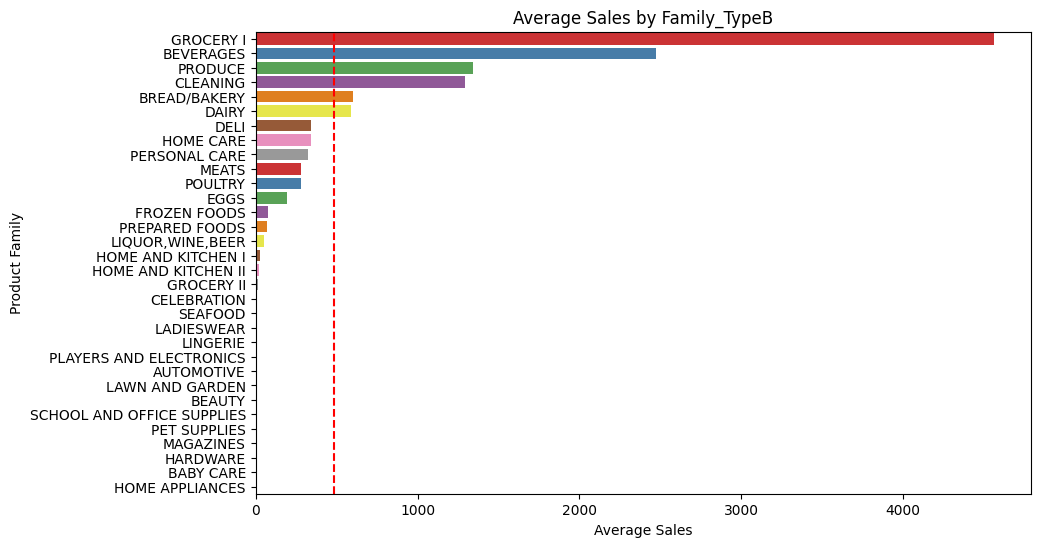

In [29]:
### 각 품목별로 매출에 미치는 영향

# 각 family 별로 'sales'의 평균을 계산하고, 내림차순으로 정렬
average_sales_by_family = typeB.groupby('family')['sales'].mean().sort_values(ascending=False)

## 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='sales', y='family', data=typeB, order=average_sales_by_family.index, ci=None, palette = 'Set1')
plt.axvline(x=typeB['sales'].mean(), color='red', linestyle='--') # 매출 전체 평균

# 그래프 제목 및 레이블 설정
plt.title('Average Sales by Family_TypeB')
plt.xlabel('Average Sales')
plt.ylabel('Product Family')
plt.show()

- `groceryI`과 `beverages`가 매출의 대부분을 차지한다.(typeA와 비슷한 특징이다.)
  > 모델링 시 제품군을 one-hot encoding 후 반영하는 것이 좋을 것이라고 판단됨

### **💚 onpromotion**

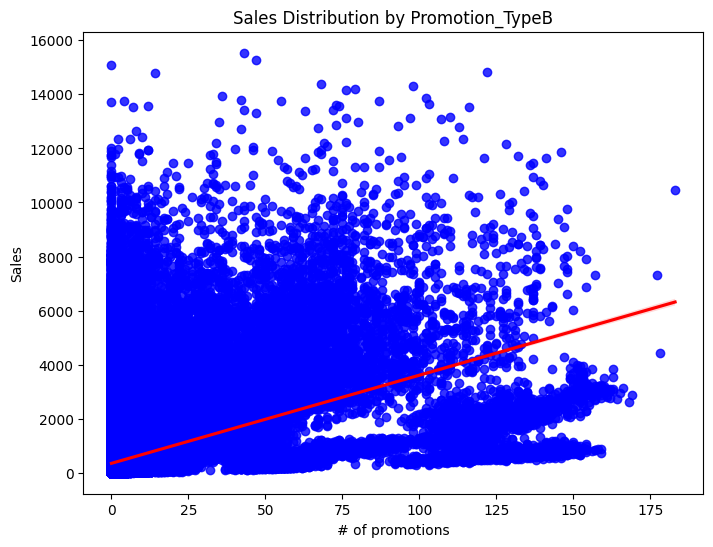

In [30]:
plt.figure(figsize=(8, 6))

sns.regplot(x='onpromotion', y='sales', data=typeB, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Promotion_TypeB')
plt.xlabel('# of promotions')
plt.ylabel('Sales')
plt.show()

- 강한 양의 상관관계를 보인다.
- promotion되는 제품 수와 상관 없이 매출액이 큰 경우들이 존재함을 확인할 수 있다.
> typeA와 동일한 특징

### **💙 state**

In [31]:
# 고유한 주(state) 수

typeB['state'].unique()

array(['Guayas', 'Azuay', 'Pichincha', 'Los Rios',
       'Santo Domingo de los Tsachilas'], dtype=object)

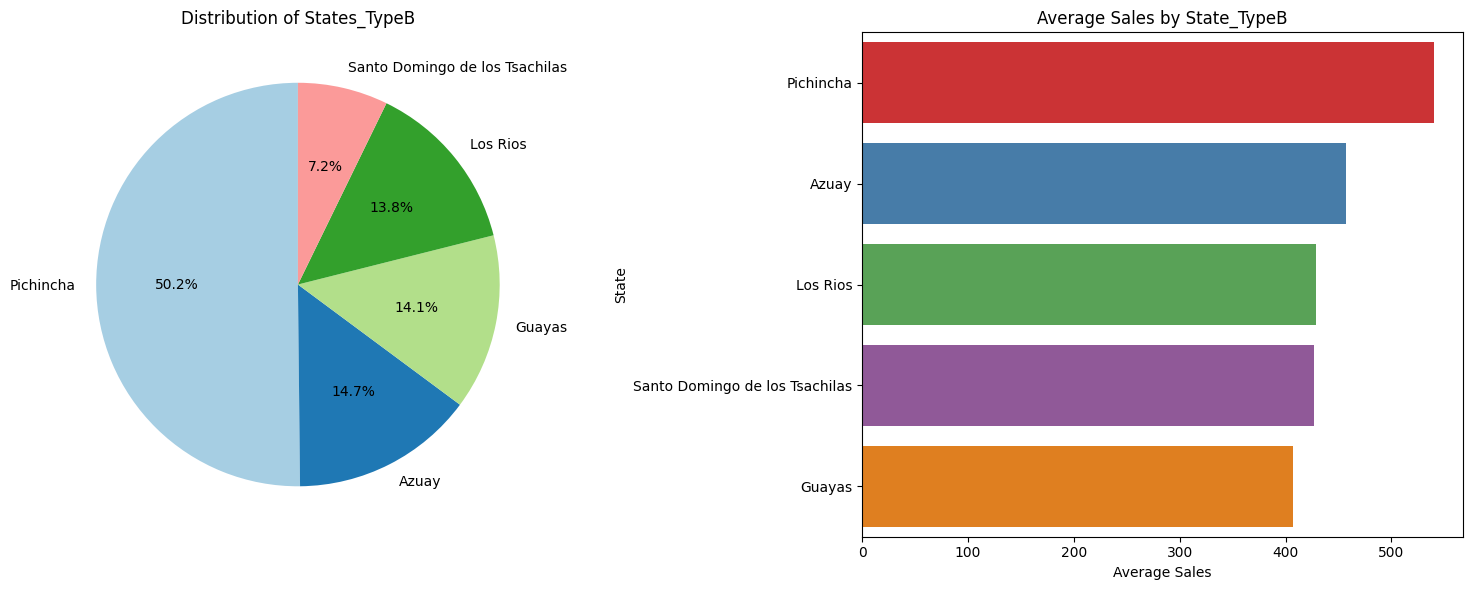

In [32]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
state_counts = typeB['state'].value_counts()
plt.pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of States_TypeB')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_state = typeB.groupby('state')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='state', data=typeB, order=average_sales_by_state.index, ci=None, palette = 'Set1')

plt.title('Average Sales by State_TypeB')
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.tight_layout()
plt.show()

- 주마다 매출액에 차이가 있음을 확인할 수 있다.
- Santo Domingo de los Tsachilas의 경우, 작은 수의 매장이 존재하지만, 큰 평균 매출을 가지고 있다.

### **💜 city**

In [33]:
# 고유한 도시(city) 수

print(typeB.groupby('state')['store_nbr'].unique())
print()
print(typeB.groupby('state')['city'].unique())

state
Azuay                                        [39]
Guayas                                       [34]
Los Rios                                     [31]
Pichincha                         [9, 18, 11, 20]
Santo Domingo de los Tsachilas               [21]
Name: store_nbr, dtype: object

state
Azuay                                     [Cuenca]
Guayas                                 [Guayaquil]
Los Rios                                [Babahoyo]
Pichincha                         [Quito, Cayambe]
Santo Domingo de los Tsachilas     [Santo Domingo]
Name: city, dtype: object


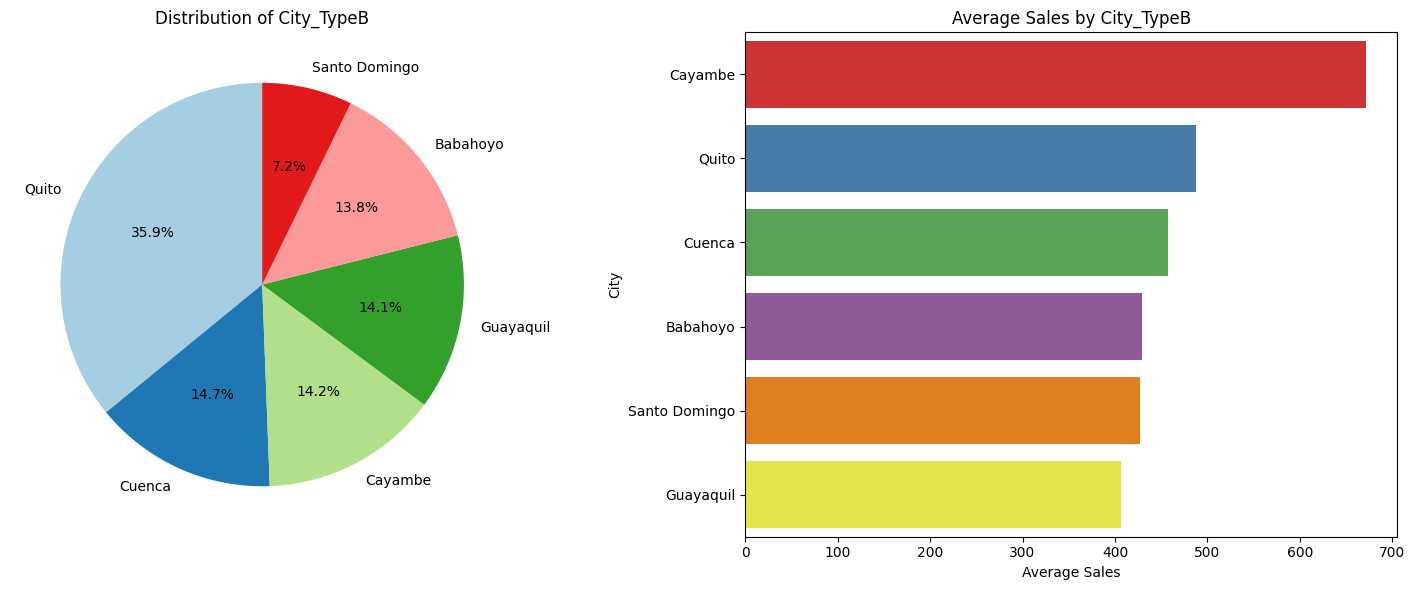

In [34]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
city_counts = typeB['city'].value_counts()
plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of City_TypeB')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_city = typeB.groupby('city')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='city', data=typeB, order=average_sales_by_city.index, ci=None, palette = 'Set1')

plt.title('Average Sales by City_TypeB')
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.tight_layout()
plt.show()

- `state`를 통해 `city`가 다 구분되는 상황
- Pichincha에는 Quito, Guayaquil 두 개의 도시가 포함되어 있으며, 나머지는 주=도시인 상황이다,
  - `sales`의 양상이 `state`와 유사
  - Quito, Guayaquil 두 도시의 특징이 다르므로, 'city'를 남기는 것이 낫지 않을까...

### **🤎dcoilwtico**

In [35]:
import plotly.express as px
import plotly.graph_objects as go

daily_oil_price = typeB.groupby("date")["dcoilwtico"].mean().reset_index()
daily_sales = typeB.groupby("date")["sales"].mean().reset_index()


# 그래프 그리기
fig = go.Figure()
fig.add_trace(go.Scatter(x = daily_oil_price["date"], y=daily_oil_price["dcoilwtico"], name="Daily DcoilWTICO Prices"))
fig.add_trace(go.Scatter(x=daily_sales["date"], y=daily_sales["sales"], name="Daily Sales"))
fig.show()

- 유가 변동 경향과 sales의 변동이 별 상관은 없어 보인다.(추세가 다름)
- 2014년을 기점으로 급격하게 감소하는 추세를 보인다.
  - 그에 비해 매출은 그렇게 오르지 않았다.

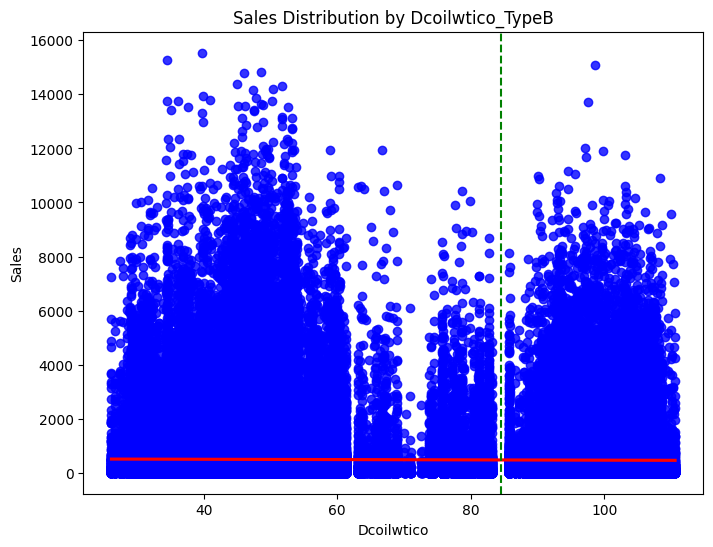

In [36]:
plt.figure(figsize=(8, 6))

sns.regplot(x='dcoilwtico', y='sales', data=typeB, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.axvline(x=84.5, color='green', linestyle='--') # 84.5 구분선

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Dcoilwtico_TypeB')
plt.xlabel('Dcoilwtico')
plt.ylabel('Sales')
plt.show()

- 정말 별 상관은 없어 보인다.
- 다만 유가가 **84.5** 전후에서 두 개의 그룹으로 확연히 분리되는 것을 확인할 수 있다.

In [37]:
under8 = typeB.loc[typeB['dcoilwtico'] <= 84.5,:]
over8 = typeB.loc[typeB['dcoilwtico'] > 84.5,:]

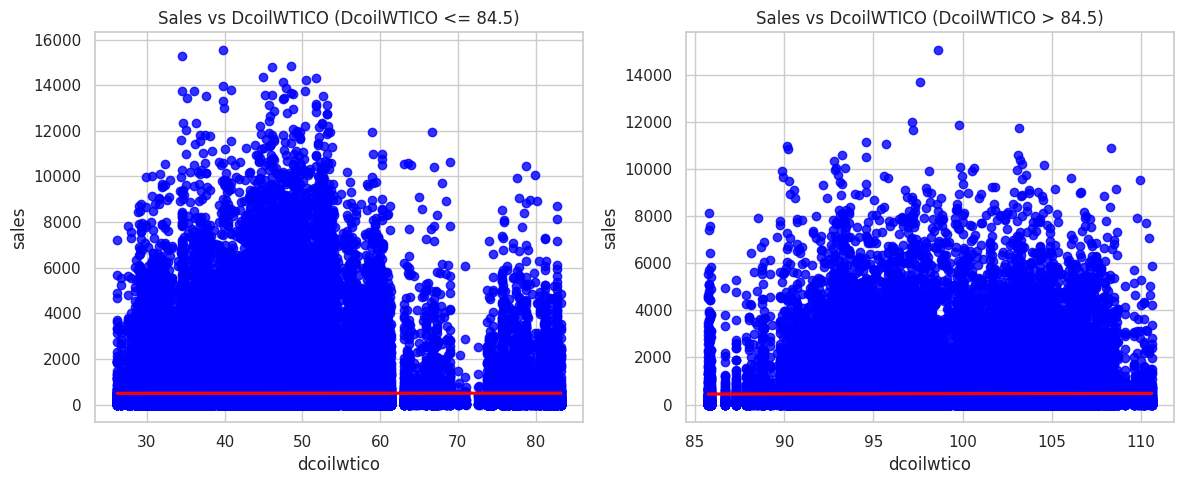

In [38]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot regplot for 'dcoilwtico' <= 84.5
sns.regplot(x='dcoilwtico', y='sales', data=under8, ax=axes[0], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axes[0].set_title('Sales vs DcoilWTICO (DcoilWTICO <= 84.5)')

# Plot regplot for 'dcoilwtico' > 84.5
sns.regplot(x='dcoilwtico', y='sales', data=over8, ax=axes[1], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axes[1].set_title('Sales vs DcoilWTICO (DcoilWTICO > 84.5)')

# Adjust layout
plt.tight_layout()
plt.show()

- 이상치 제거 후에는 다른 점이 크게 보이지 않는다.

### **💗 transactions**

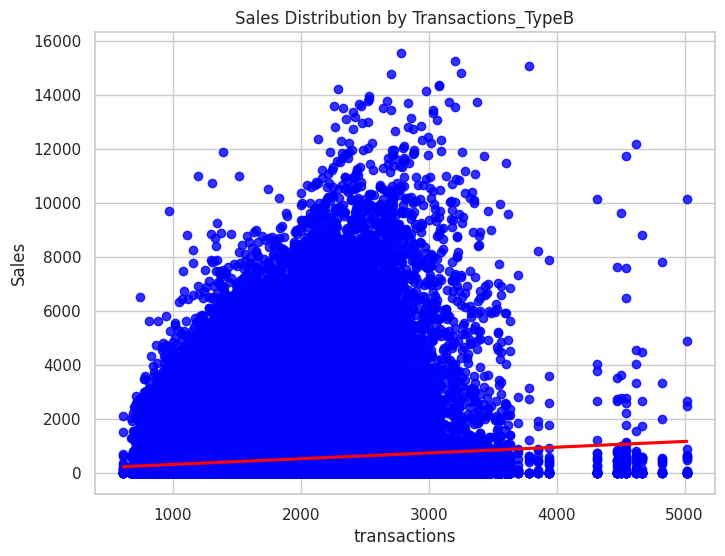

In [39]:
plt.figure(figsize=(8, 6))

sns.regplot(x='transactions', y='sales', data=typeB, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Transactions_TypeB')
plt.xlabel('transactions')
plt.ylabel('Sales')
plt.show()

- 약한 양의 상관관계를 보인다.
- 그닥 상관은 없어 보인다.  
(어짜피 모델링 시 활용하기 어려움..)

### **🤍 holiday**

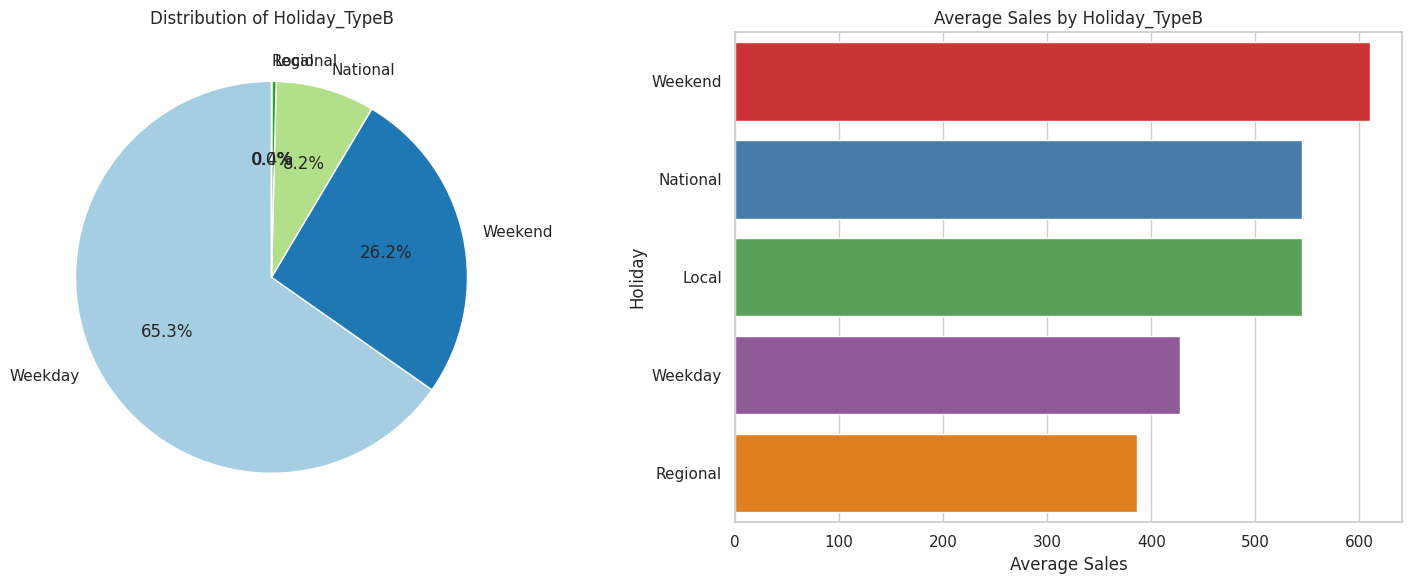

In [40]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
holiday_counts = typeB['holiday'].value_counts()
plt.pie(holiday_counts, labels=holiday_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Holiday_TypeB')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_holiday = typeB.groupby('holiday')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='holiday', data=typeB, order=average_sales_by_holiday.index, ci=None, palette = 'Set1')

plt.title('Average Sales by Holiday_TypeB')
plt.xlabel('Average Sales')
plt.ylabel('Holiday')
plt.tight_layout()
plt.show()

- Regional의 매출이 가장 좋다.

### **⭐Target 변수(Sales)**
- 여러 요인에 따라 매출이 어떻게 달라지는지 살펴보자.

#### **a) 시간 관련 변수**

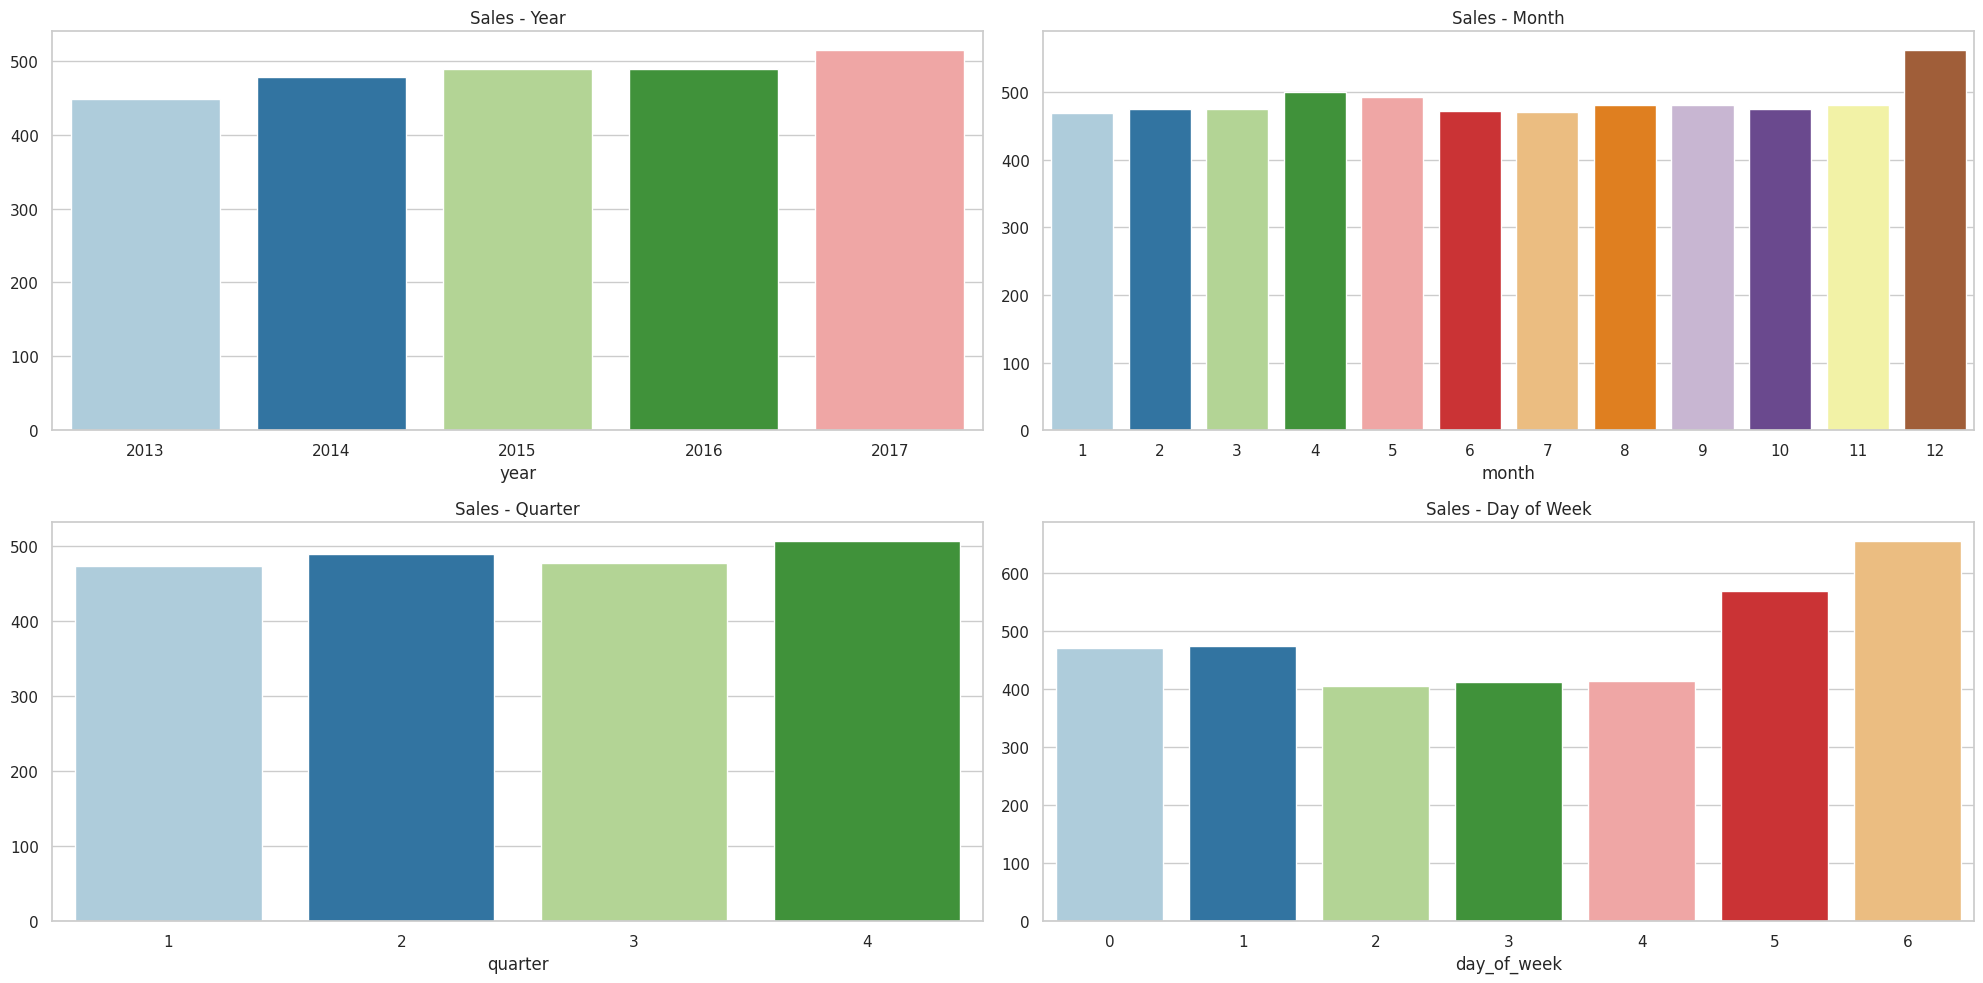

In [41]:
### 평균 매출액으로 시각화
data_grouped_year = typeB.groupby(['year']).mean()['sales']
data_grouped_month = typeB.groupby(['month']).mean()['sales']
data_grouped_quarter = typeB.groupby(['quarter']).mean()['sales']
data_grouped_day = typeB.groupby(['day_of_week']).mean()['sales']

palette = sns.color_palette("Paired")

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# 연도별 매출
axes[0, 0].set_title('Sales - Year')
sns.barplot(x=data_grouped_year.index, y=data_grouped_year.values, ax=axes[0, 0], palette=palette)
# 월별 매출
axes[0, 1].set_title('Sales - Month')
sns.barplot(x=data_grouped_month.index, y=data_grouped_month.values, ax=axes[0, 1], palette=palette)
# 분기별 매출
axes[1, 0].set_title('Sales - Quarter')
sns.barplot(x=data_grouped_quarter.index, y=data_grouped_quarter.values, ax=axes[1, 0], palette=palette)
# 요일별 매출
axes[1, 1].set_title('Sales - Day of Week')
sns.barplot(x=data_grouped_day.index, y=data_grouped_day.values, ax=axes[1, 1], palette=palette)

plt.tight_layout()
plt.show()

**연도별 매출**
- 뒤로 갈수록 매출액이 점점 증가하고 있다.

**월별 & 분기별 매출**  
- 대체로 비슷한 경향을 보이나, 12월에 매출이 증가
- 4분기에 매출 증가

**요일별 매출**  
- 평일에 비해 주말의 매출액이 더 높다.
- 그 중 6인 일요일의 매출이 가장 높다.

#### **b) 변수들 간의 상관관계**
- 상관계수는 수치형 변수들끼리만 비교 가능

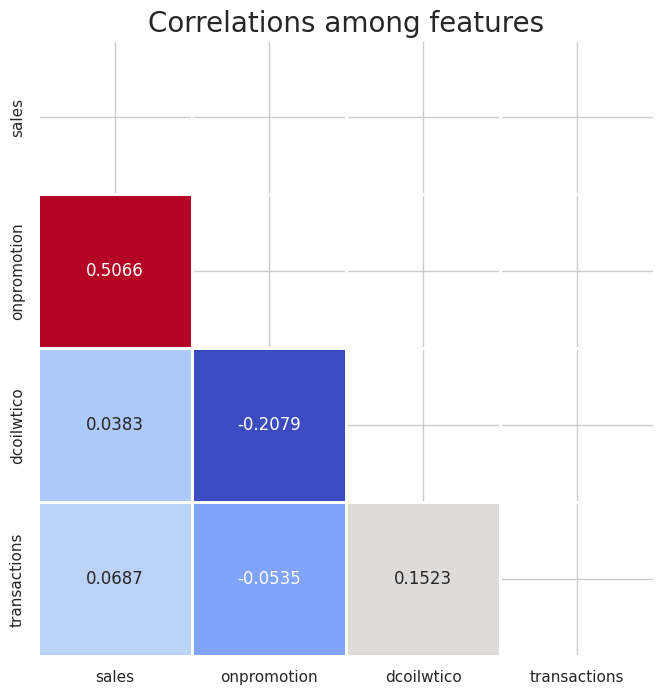

In [43]:
num_ftrs = typeB[['sales', 'onpromotion','dcoilwtico','transactions']]

mask = np.triu(num_ftrs.corr(method = 'spearman'))

# heatmap을 이용한 시각화
plt.figure(figsize=(8, 8))
sns.heatmap(num_ftrs.corr(method = 'spearman'),
            annot=True,
            fmt='.4f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)
plt.title("Correlations among features", fontsize=20)
plt.show()

### **💡 후처리**

#### **최종 변수 선택**

In [44]:
typeB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293993 entries, 1654 to 2704949
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            293993 non-null  int64         
 1   date          293993 non-null  datetime64[ns]
 2   store_nbr     293993 non-null  int64         
 3   family        293993 non-null  object        
 4   sales         293993 non-null  float64       
 5   onpromotion   293993 non-null  float64       
 6   city          293993 non-null  object        
 7   state         293993 non-null  object        
 8   cluster       293993 non-null  int64         
 9   dcoilwtico    293993 non-null  float64       
 10  transactions  293528 non-null  float64       
 11  holiday       293993 non-null  object        
 12  year          293993 non-null  int64         
 13  quarter       293993 non-null  int64         
 14  month         293993 non-null  int64         
 15  day_of_week  

In [45]:
typeB = typeB[['store_nbr', 'family', 'sales', 'onpromotion', 'city', 'cluster', 'dcoilwtico', 'holiday', 'year', 'quarter', 'month', 'day_of_week']]
# typeA와 달리 city를 남겨두기로 결정함

# test의 경우에는 이후 submission 파일 작성을 위해 일단 id를 남겨두기로 결정
typeB_te = typeB_te[['id', 'store_nbr', 'family', 'onpromotion', 'city', 'cluster', 'dcoilwtico', 'holiday', 'year', 'quarter', 'month', 'day_of_week']]

In [46]:
typeB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293993 entries, 1654 to 2704949
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   store_nbr    293993 non-null  int64  
 1   family       293993 non-null  object 
 2   sales        293993 non-null  float64
 3   onpromotion  293993 non-null  float64
 4   city         293993 non-null  object 
 5   cluster      293993 non-null  int64  
 6   dcoilwtico   293993 non-null  float64
 7   holiday      293993 non-null  object 
 8   year         293993 non-null  int64  
 9   quarter      293993 non-null  int64  
 10  month        293993 non-null  int64  
 11  day_of_week  293993 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 29.2+ MB


#### **Train/Validation Split**

In [47]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(typeB, test_size=0.3, random_state=42, stratify=typeB[['store_nbr', 'family']]) # 가게별, 제품군별 비율 유지

In [48]:
train.shape

(205795, 12)

In [49]:
val.shape

(88198, 12)

#### **변수 왜곡 정도 확인**

In [50]:
# 수치형 변수들에 대해서만 왜도 확인

train[['sales', 'onpromotion','dcoilwtico']].skew()

sales         4.21
onpromotion   5.77
dcoilwtico    0.77
dtype: float64

In [51]:
train['sales'] = np.log1p(train['sales'])
train['onpromotion'] = np.log1p(train['onpromotion'])

In [52]:
train[['sales', 'onpromotion','dcoilwtico']].skew()

sales         0.16
onpromotion   2.03
dcoilwtico    0.77
dtype: float64

- 왜곡 정도가 많이 개선되었다.

In [53]:
val['onpromotion'] = np.log1p(val['onpromotion'])
typeB_te['onpromotion'] = np.log1p(typeB_te['onpromotion'])

#### **스케일링**
- 수치형 변수들에 대한 스케일링 진행

In [54]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected variables
train[['onpromotion', 'dcoilwtico']] = scaler.fit_transform(train[['onpromotion', 'dcoilwtico']])
val[['onpromotion', 'dcoilwtico']] = scaler.transform(val[['onpromotion', 'dcoilwtico']])
typeB_te[['onpromotion', 'dcoilwtico']] = scaler.transform(typeB_te[['onpromotion', 'dcoilwtico']])

In [55]:
train.head()

,store_nbr,family,sales,onpromotion,city,cluster,dcoilwtico,holiday,year,quarter,month,day_of_week
1360971,9,BEVERAGES,8.66,-0.52,Quito,6,-0.08,Weekend,2015,2,6,6
883009,39,EGGS,5.23,0.11,Cuenca,6,1.51,Weekday,2014,3,8,0
768824,18,DELI,5.14,3.02,Quito,16,1.77,Weekday,2014,2,5,3
2054721,31,PLAYERS AND ELECTRONICS,2.48,-0.52,Babahoyo,10,-0.88,Weekend,2016,3,7,6
722468,9,SEAFOOD,2.28,-0.52,Quito,6,1.64,Weekday,2014,2,4,0


In [56]:
val.head()

,store_nbr,family,sales,onpromotion,city,cluster,dcoilwtico,holiday,year,quarter,month,day_of_week
1632544,18,BEAUTY,4.00,-0.52,Quito,16,-0.85,Weekday,2015,4,11,2
2546913,18,DELI,305.29,1.59,Quito,16,-0.54,Weekday,2017,2,5,1
118121,39,BREAD/BAKERY,517.00,-0.52,Cuenca,6,1.32,Weekday,2013,1,3,4
1745770,34,SEAFOOD,1.00,-0.52,Guayaquil,6,-1.22,Weekend,2016,1,1,6
1635636,9,PET SUPPLIES,4.00,-0.52,Quito,6,-0.88,National,2015,4,11,4


In [57]:
typeB_te.head()

,id,store_nbr,family,onpromotion,city,cluster,dcoilwtico,holiday,year,quarter,month,day_of_week
66,3000954,11,AUTOMOTIVE,-0.52,Cayambe,6,-0.62,Weekday,2017,3,8,2
67,3000955,11,BABY CARE,-0.52,Cayambe,6,-0.62,Weekday,2017,3,8,2
68,3000956,11,BEAUTY,0.48,Cayambe,6,-0.62,Weekday,2017,3,8,2
69,3000957,11,BEVERAGES,3.12,Cayambe,6,-0.62,Weekday,2017,3,8,2
70,3000958,11,BOOKS,-0.52,Cayambe,6,-0.62,Weekday,2017,3,8,2


#### **범주형 변수 처리**

In [58]:
train = pd.get_dummies(train, columns=['store_nbr','family', 'city', 'cluster', 'holiday', 'year', 'quarter', 'month', 'day_of_week'])
train.head()

,sales,onpromotion,dcoilwtico,store_nbr_9,store_nbr_11,store_nbr_18,store_nbr_20,store_nbr_21,store_nbr_31,store_nbr_34,store_nbr_39,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,city_Babahoyo,city_Cayambe,city_Cuenca,city_Guayaquil,city_Quito,city_Santo Domingo,cluster_6,cluster_10,cluster_16,holiday_Local,holiday_National,holiday_Regional,holiday_Weekday,holiday_Weekend,year_2013,year_2014,year_2015,year_2016,year_2017,quarter_1,quarter_2,quarter_3,quarter_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
1360971,8.66,-0.52,-0.08,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
883009,5.23,0.11,1.51,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
768824,5.14,3.02,1.77,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2054721,2.48,-0.52,-0.88,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
722468,2.28,-0.52,1.64,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [59]:
train.shape

(205795, 85)

In [60]:
val = pd.get_dummies(val, columns=['store_nbr','family', 'city', 'cluster', 'holiday', 'year', 'quarter', 'month', 'day_of_week'])
val.head()

,sales,onpromotion,dcoilwtico,store_nbr_9,store_nbr_11,store_nbr_18,store_nbr_20,store_nbr_21,store_nbr_31,store_nbr_34,store_nbr_39,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,city_Babahoyo,city_Cayambe,city_Cuenca,city_Guayaquil,city_Quito,city_Santo Domingo,cluster_6,cluster_10,cluster_16,holiday_Local,holiday_National,holiday_Regional,holiday_Weekday,holiday_Weekend,year_2013,year_2014,year_2015,year_2016,year_2017,quarter_1,quarter_2,quarter_3,quarter_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
1632544,4.00,-0.52,-0.85,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2546913,305.29,1.59,-0.54,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
118121,517.00,-0.52,1.32,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1745770,1.00,-0.52,-1.22,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1635636,4.00,-0.52,-0.88,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [61]:
val.shape

(88198, 85)

- 84개의 feature 변수, 1개의 target 변수

In [62]:
typeB_te = pd.get_dummies(typeB_te, columns=['store_nbr','family', 'city', 'cluster', 'holiday', 'year', 'quarter', 'month', 'day_of_week'])
typeB_te.head()

,id,onpromotion,dcoilwtico,store_nbr_9,store_nbr_11,store_nbr_18,store_nbr_20,store_nbr_21,store_nbr_31,store_nbr_34,store_nbr_39,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,city_Babahoyo,city_Cayambe,city_Cuenca,city_Guayaquil,city_Quito,city_Santo Domingo,cluster_6,cluster_10,cluster_16,holiday_Weekday,holiday_Weekend,year_2017,quarter_3,month_8,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
66,3000954,-0.52,-0.62,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1,0,0,1,0,0,0,0
67,3000955,-0.52,-0.62,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1,0,0,1,0,0,0,0
68,3000956,0.48,-0.62,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1,0,0,1,0,0,0,0
69,3000957,3.12,-0.62,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1,0,0,1,0,0,0,0
70,3000958,-0.52,-0.62,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1,0,0,1,0,0,0,0


In [63]:
typeB_te.shape

(4224, 65)

- 차이가 나는 부분
  - holiday(local, regional, national > 3개)
  - year(2013, 2014, 2015, 2016 > 4개)
  - quarter(1,2,4 > 3개)
  - month(1,2,3,4,5,6,7,9,10,11,12 > 11개)
  - id(-1개)

In [64]:
## 변수 추가

typeB_te[['holiday_Local','holiday_Regional','holiday_National', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2', 'quarter_4']] = 0

In [65]:
typeB_te.shape

(4224, 86)

In [66]:
train.columns.difference(typeB_te.columns)

Index(['sales'], dtype='object')

In [67]:
typeB_te.columns.difference(train.columns)

Index(['family_BOOKS', 'id'], dtype='object')

In [68]:
typeB_te.columns.difference(val.columns)

Index(['family_BOOKS', 'id'], dtype='object')

- typeB에 속하는 매장들은 `BOOKS` 제품군을 판매하지 x
  - 모델링 시에는 삭제
- 이후 예측값을 다 0으로 표시


In [69]:
# 최종 파일 저장

train.to_csv('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/train/trainB.csv', index = False)
val.to_csv('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/val/valB.csv', index = False)
typeB_te.to_csv('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/test/testB.csv', index = False)